Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 180, 32)             │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 180, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,217 (51.63 KB)

 Trainable params: 13,217 (51.63 KB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.1827 - val_loss: 0.0065
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0201 - val_loss: 0.0045
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0157 - val_loss: 0.0050
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 0.0130 - val_loss: 0.0040
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0116 - val_loss: 0.0044
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0107 - val_loss: 0.0045
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.0099 - val_loss: 0.0039
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0091 - val_loss: 0.0038
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.0093 - val_loss: 0.0039
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.0099 - val_loss: 0.0037
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0101 - val_loss: 0.0036
Epoch 12/100
19/19

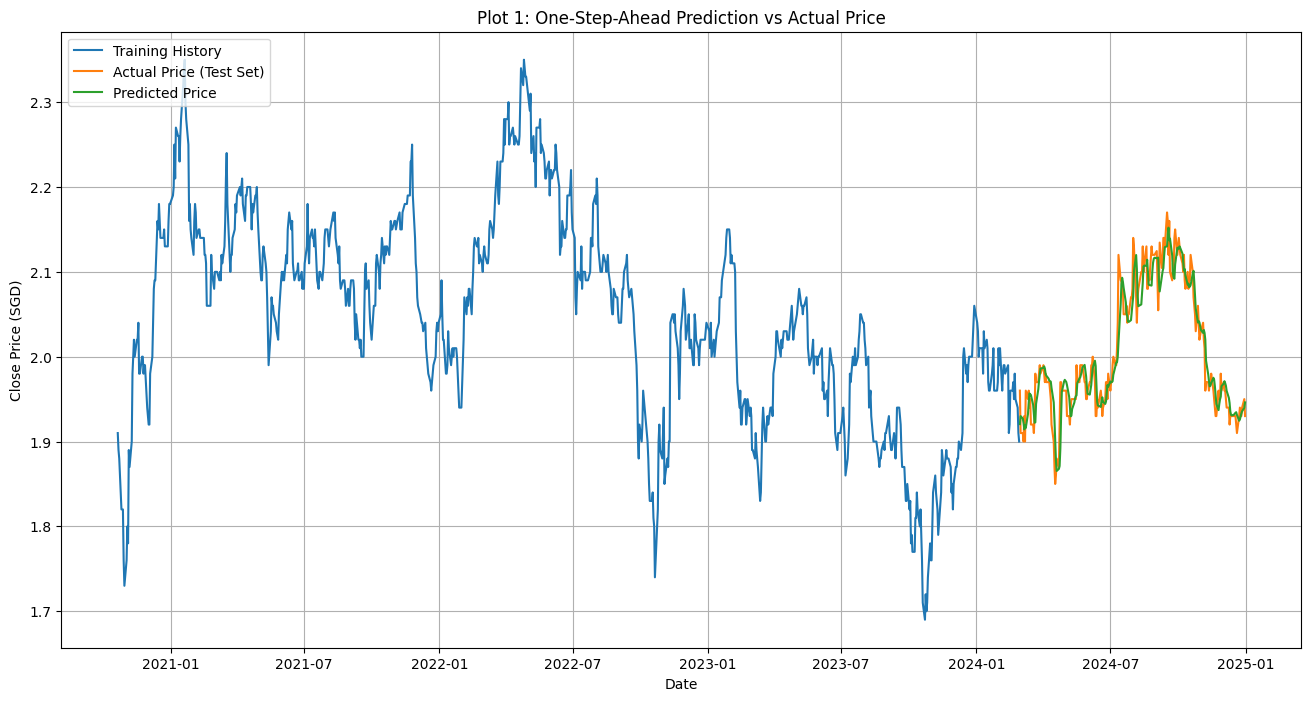


--- Starting Iterative Trend Forecasting for 90 days ---


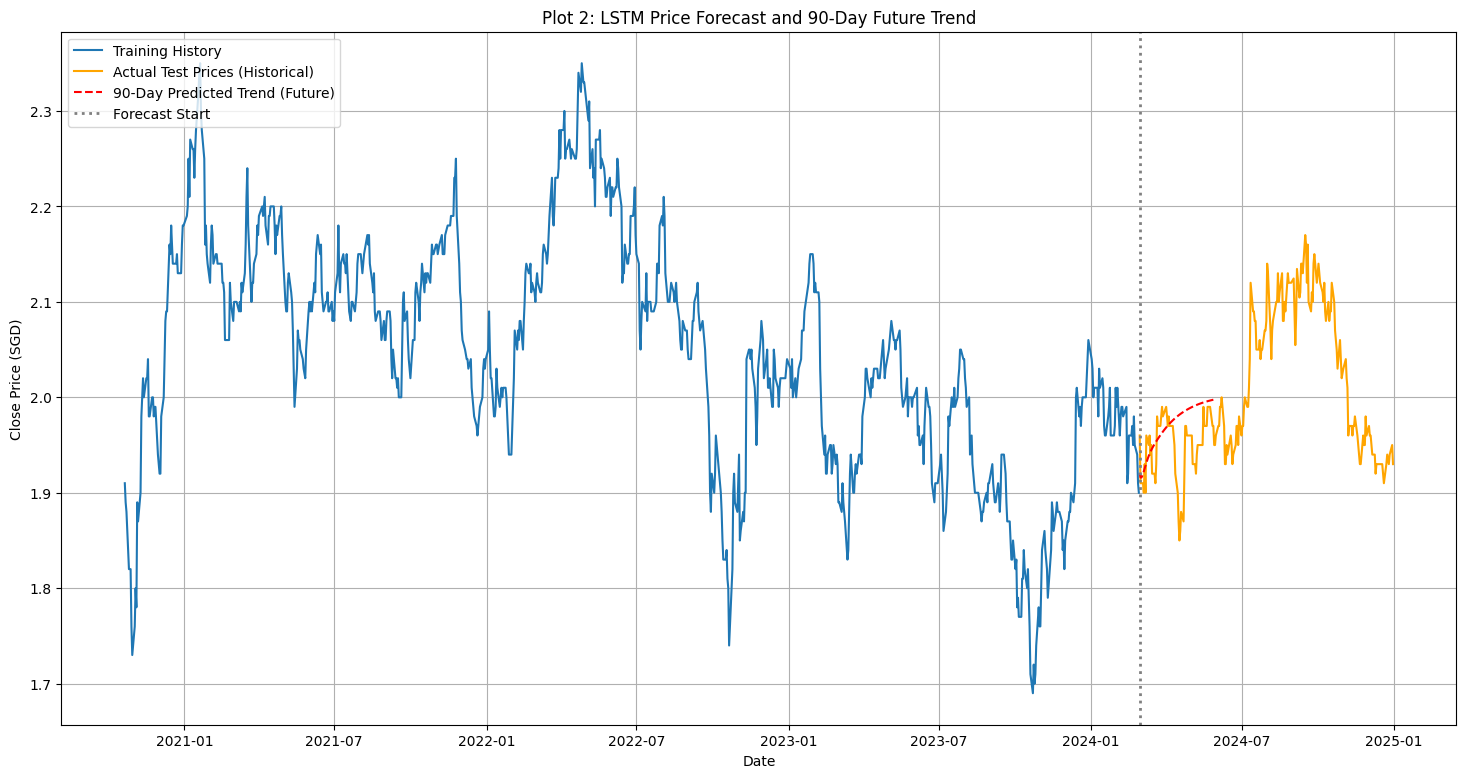


--- 90-Day Trend Analysis ---
Forecast Start Price: 1.9205
Forecast End Price: 1.9975
Overall Predicted Change: 4.01%
CONCLUSION: Predicted long-term trend is UP (BULLISH).


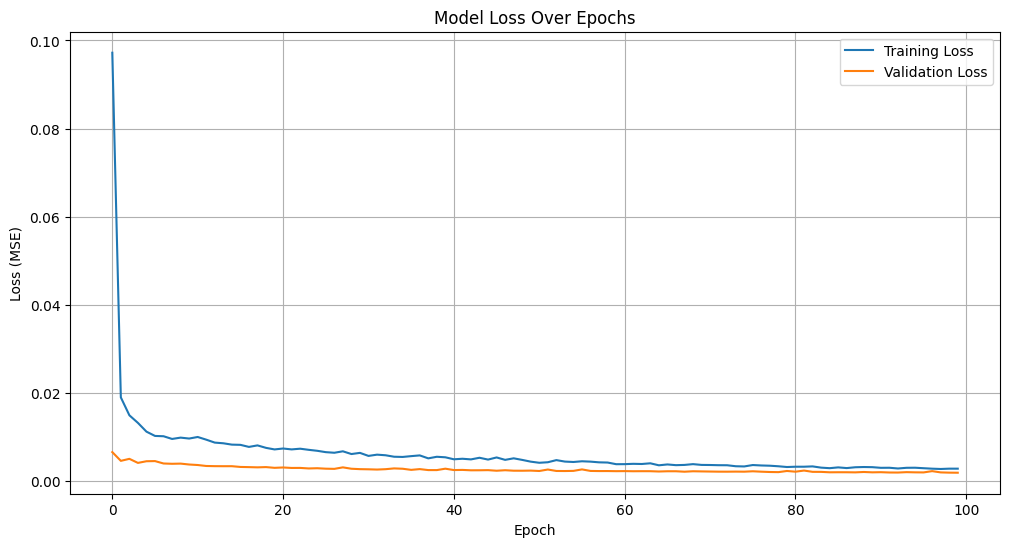

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# --- 1. Load and Prepare Data ---
try:
    df = pd.read_csv('calculated_averages/C38U.SI_stock_price_history_with_indicators.csv', parse_dates=['Date'], index_col='Date')
except FileNotFoundError:
    print("Error: CSV file not found. Please check that the file path is correct.")
    exit()

# We only need the 'Close' price for this example
data = df.filter(['Close'])
dataset = data.values # Convert to numpy array

# MinMaxScaler Scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# --- 2. Create Sequences ---
SEQ_LEN = 180 # Look-back window

# Split data into training and testing sets (80% train, 20% test)
train_data_len = int(np.ceil(len(dataset) * .8))
train_data = scaled_data[0:int(train_data_len), :]

# Create the training data set
x_train = []
y_train = []
for i in range(SEQ_LEN, len(train_data)):
    x_train.append(train_data[i-SEQ_LEN:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# --- 3. Build the LSTM Model (Corrected) ---
model = Sequential()
# Add the Input layer first to define the shape, this removes the warning
model.add(Input(shape=(x_train.shape[1], 1)))
# The LSTM layer no longer needs the input_shape argument
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# --- 4. Train and Save the Model ---
print("\nTraining the model...")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=100,
    callbacks=[early_stop],
    validation_split=0.1
)

# Save the trained model
print("\n--- Saving the trained model to 'univariate_lstm_model_base_model.keras' ---")
model.save('univariate_lstm_model_base_model.keras')

# --------------------------------------------------------------------------------------
# --- PART A: ONE-STEP-AHEAD EVALUATION ON TEST SET ---
# --------------------------------------------------------------------------------------

# --- 5. Create the Testing Data Set ---
test_data = scaled_data[train_data_len - SEQ_LEN:, :]
x_test = []
y_test = dataset[train_data_len:, :]

for i in range(SEQ_LEN, len(test_data)):
    x_test.append(test_data[i-SEQ_LEN:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# --- 6. Get the Model's Predicted Price Values ---
print("\nEvaluating the model on the test set...")
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# --- 7. Evaluate Model Performance ---
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# --- 8. Visualize the Test Set Predictions ---
train_plot_data = data[:train_data_len]
valid_plot_data = data[train_data_len:].copy()
valid_plot_data['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Plot 1: One-Step-Ahead Prediction vs Actual Price')
plt.xlabel('Date')
plt.ylabel('Close Price (SGD)')
plt.plot(train_plot_data['Close'], label='Training History')
plt.plot(valid_plot_data['Close'], label='Actual Price (Test Set)')
plt.plot(valid_plot_data['Predictions'], label='Predicted Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


# --------------------------------------------------------------------------------------
# --- PART B: 90-DAY FUTURE FORECAST ---
# --------------------------------------------------------------------------------------

# --- 9. Perform Iterative Forecasting for Future Trend ---
N_STEPS = 90
print(f"\n--- Starting Iterative Trend Forecasting for {N_STEPS} days ---")

initial_sequence = scaled_data[train_data_len - SEQ_LEN:train_data_len]
current_input = initial_sequence.reshape(1, SEQ_LEN, 1)
future_predictions_scaled = []

for i in range(N_STEPS):
    next_prediction_scaled = model.predict(current_input, verbose=0)[0, 0]
    future_predictions_scaled.append(next_prediction_scaled)
    
    new_input_list = current_input[0, :, 0].tolist()
    new_input_list.pop(0)
    new_input_list.append(next_prediction_scaled)
    current_input = np.array(new_input_list).reshape(1, SEQ_LEN, 1)

predictions_array = np.array(future_predictions_scaled).reshape(-1, 1)
future_predictions_price = scaler.inverse_transform(predictions_array)

last_train_date = df.index[train_data_len - 1]
future_dates = pd.date_range(start=last_train_date, periods=N_STEPS + 1, inclusive='right')
future_df = pd.DataFrame(
    future_predictions_price,
    index=future_dates,
    columns=['Predicted_Trend_Price']
)

# --- 10. Visualize the Future Forecast Results ---
train = data[:train_data_len]
valid = data[train_data_len:]

plt.figure(figsize=(18, 9))
plt.title(f'Plot 2: LSTM Price Forecast and {N_STEPS}-Day Future Trend')
plt.xlabel('Date')
plt.ylabel('Close Price (SGD)')
plt.plot(train['Close'], label='Training History')
plt.plot(valid['Close'], label='Actual Test Prices (Historical)', color='orange')
plt.plot(future_df['Predicted_Trend_Price'], label=f'{N_STEPS}-Day Predicted Trend (Future)', color='red', linestyle='--')
forecast_start_date = future_df.index[0]
plt.axvline(x=forecast_start_date, color='grey', linestyle=':', linewidth=2, label='Forecast Start')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


# --------------------------------------------------------------------------------------
# --- PART C: MODEL DIAGNOSTICS & ANALYSIS ---
# --------------------------------------------------------------------------------------

# --- 11. Trend Analysis and Conclusion ---
print(f'\n--- {N_STEPS}-Day Trend Analysis ---')
if not future_df.empty:
    start_price = future_df.iloc[0]['Predicted_Trend_Price']
    end_price = future_df.iloc[-1]['Predicted_Trend_Price']
    trend_change = ((end_price - start_price) / start_price) * 100

    print(f'Forecast Start Price: {start_price:.4f}')
    print(f'Forecast End Price: {end_price:.4f}')
    print(f'Overall Predicted Change: {trend_change:.2f}%')
    
    if trend_change > 1.0:
        print('CONCLUSION: Predicted long-term trend is UP (BULLISH).')
    elif trend_change < -1.0:
        print('CONCLUSION: Predicted long-term trend is DOWN (BEARISH).')
    else:
        print('CONCLUSION: Predicted long-term trend is relatively FLAT (SIDEWAYS).')
else:
    print('Forecasting failed or resulted in an empty trend DataFrame.')

# --- 12. Visualize Training Loss ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()